# Evaluation for Extrapolating the Learning Curves

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

results_file = os.path.expanduser('../results/extrapolation.csv')
df = pd.read_csv(results_file)

classifiers = df['classifier'].unique()
df

,Unnamed: 0,task_id,classifier,performance_curve_end,performance_prediction,performance_next_point,delta_current_prediction,delta_current_actual
0,0,359956,LinearSVC(),0.213636,0.144585,0.153227,0.069052,0.060410
1,1,359956,DecisionTreeClassifier(),0.259091,0.232342,0.190069,0.026749,0.069022
2,2,359956,ExtraTreeClassifier(),0.240000,0.228410,0.202444,0.011590,0.037556
3,3,359956,LogisticRegression(),0.172273,0.136411,0.125125,0.035862,0.047147
4,4,359956,PassiveAggressiveClassifier(),0.245000,0.217628,0.204073,0.027372,0.040927
...,...,...,...,...,...,...,...,...
949,949,359981,BernoulliNB(),0.350910,0.348205,0.348330,0.002705,0.002580
950,950,359981,KNeighborsClassifier(),0.193230,0.190254,0.243188,0.002976,-0.049958
951,951,359981,ExtraTreesClassifier(),0.197140,0.195345,0.221544,0.001795,-0.024404
952,952,359981,RandomForestClassifier(),0.184910,0.183624,0.211052,0.001286,-0.026142


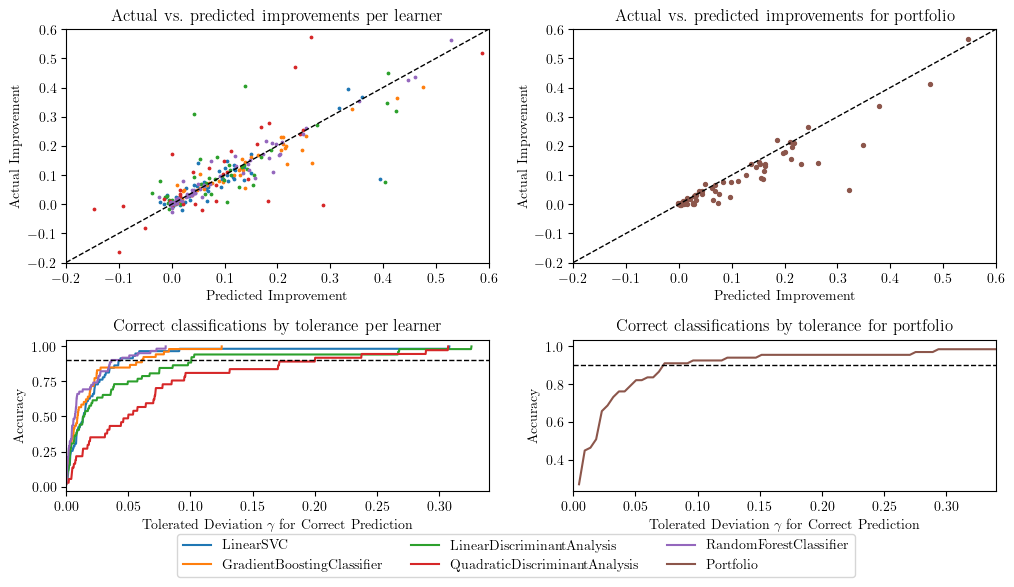

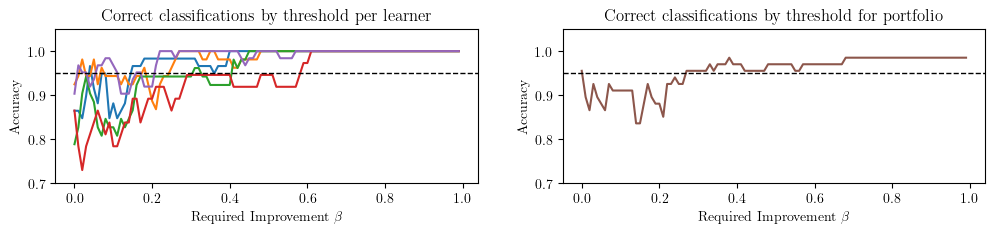

In [2]:
fig_cor, axes_regr  = plt.subplots(2, 2, figsize=(12,6), gridspec_kw={'hspace': 0.4, 'height_ratios': [2, 1.3]})
fig_acc, axes_clas  = plt.subplots(1, 2, figsize=(12,2))

axes_cor = axes_regr[0]
axes_precision = axes_regr[1]
axes_acc = axes_clas

for classifier in ["LinearSVC()", "GradientBoostingClassifier()", "LinearDiscriminantAnalysis()", "QuadraticDiscriminantAnalysis()", "RandomForestClassifier()"]:
    result_clf = df.loc[df['classifier'] == classifier]
    
    # for regression acc plot
    perf = np.abs(result_clf['performance_next_point'] - result_clf['performance_prediction']).values
    count, bins_count = np.histogram(perf, bins=1000)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    # for curve plot
    curve_plot_x = np.arange(0, 1, 0.01)
    curve_plot_y = []
    for i in curve_plot_x:
        cur_val = ((result_clf['delta_current_actual'] < i) & (result_clf['delta_current_prediction'].values < i)) | ((result_clf['delta_current_actual'].values >= i) & (result_clf['delta_current_prediction'].values >= i))
        curve_plot_y.append(sum(cur_val) / len(cur_val))
    # adds to general plot
    axes_cor[0].scatter(result_clf['delta_current_prediction'], result_clf['delta_current_actual'], s=3)
    axes_cor[0].set_title("Actual vs. predicted improvements per learner")
    axes_precision[0].plot(bins_count[1:], cdf, label=classifier[:-2])
    axes_precision[0].set_title("Correct classifications by tolerance per learner")
    axes_acc[0].plot(curve_plot_x, curve_plot_y)
    axes_acc[0].set_title("Correct classifications by threshold per learner")

### now for the portfolio selection (based on FULL portfolio)
best_actual = []
best_predicted = []
for dataset, df_dataset in df.groupby("task_id"):
    # best performing classifier at halfway point (lower is better)
    best_score_on_half = min(df_dataset["performance_curve_end"])
    # best performing classifier at full point (lower is better)
    best_score_on_full = min(df_dataset['performance_next_point'])
    # delta of the best obtained score at full point minus halfway point (higher is better!)
    delta_best = best_score_on_half - best_score_on_full
    # per-classifier prediction how much it will improve over the best classifier so far (higher is better)
    df_dataset['delta_currentbest_prediction'] = best_score_on_half - df_dataset["performance_prediction"]
    # the best predicted performance gain (maximize)
    best_predicted_delta = max(df_dataset["delta_currentbest_prediction"])
    
    best_actual.append(delta_best)
    best_predicted.append(best_predicted_delta)
best_actual = np.array(best_actual)
best_predicted = np.array(best_predicted)

# for regression acc plot
perf = np.abs(best_actual - best_predicted)
count, bins_count = np.histogram(perf, bins=1000)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

# for curve plot
curve_plot_x = np.arange(0, 1, 0.01)
curve_plot_y = []
for i in curve_plot_x:
    cur_val = ((best_actual < i) & (best_predicted < i)) | ((best_actual >= i) & (best_predicted >= i))
    curve_plot_y.append(sum(cur_val) / len(cur_val)) 

portfolio_color = "C5"
axes_cor[1].scatter(best_predicted, best_actual, s=8, color=portfolio_color)
axes_cor[1].set_title("Actual vs. predicted improvements for portfolio")
axes_precision[1].plot(bins_count[1:], cdf, color=portfolio_color, label="Portfolio")
axes_precision[1].set_title("Correct classifications by tolerance for portfolio")
axes_acc[1].plot(curve_plot_x, curve_plot_y, color=portfolio_color)
axes_acc[1].set_title("Correct classifications by threshold for portfolio")
    
for col in range(2):
    axes_cor[col].set_xlim([-0.2, 0.6])
    axes_cor[col].set_ylim([-0.2, 0.6])
    axes_cor[col].plot([-0.2, 1], [-0.2, 1], linestyle="--", linewidth=1, color="black")
    
    axes_precision[col].set_xlim([0, 0.34])
    axes_acc[col].set_ylim([0.7,1.05])
    
    axes_cor[col].set_xlabel("Predicted Improvement")
    axes_cor[col].set_ylabel("Actual Improvement")
    axes_precision[col].set_xlabel("Tolerated Deviation $\\gamma$ for Correct Prediction")
    axes_precision[col].axhline(0.9, linestyle="--", linewidth=1, color="black")
    axes_precision[col].set_ylabel("Accuracy")
    axes_acc[col].set_xlabel("Required Improvement $\\beta$")
    axes_acc[col].set_ylabel("Accuracy")
    axes_acc[col].axhline(0.95, linestyle="--", linewidth=1, color="black")

handles, labels = axes_precision[0].get_legend_handles_labels()
handles_port, labels_port = axes_precision[1].get_legend_handles_labels()
# note that legend only is in axes acc[0][.]
handles.extend(handles_port)
labels.extend(labels_port)
lgd = fig_cor.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
#fig.tight_layout()
fig_cor.savefig("plots/results-correlation.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig_acc.savefig("plots/results-accuracy.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
# print('results on %d tasks:' % len(result_clf['task_id']), result_clf['task_id'].values)